In [1]:
#Based on tutorial: https://machinelearningmastery.com/random-forest-ensemble-in-python/
#Run this code before you can classify

# Use numpy to convert to arrays
import numpy as np
from numpy import mean, std

# Pandas is used for data manipulation
import pandas as pd

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

In [182]:
#load in the dataset
features = pd.read_csv('heloc_dataset_v1.csv')
features.replace([-9, -8, -7], np.nan, inplace=True)

#the columns that stores the labels
labelDimension = "RiskPerformance"

original_rows = features.shape[0]

features = features.dropna(thresh=10) # Remove rows with more than 10 missing values
print("Removed rows:", original_rows - features.shape[0])
features.drop(features.columns[features.isnull().sum() > 1000], axis=1, inplace=True)
# bins = [0, 20, 40, 60, 80, 100]
# labels =[0, 1, 2, 3, 4]
# features['ExternalRiskEstimateCat'] = pd.cut(features['ExternalRiskEstimate'], bins, labels=labels)
categorical = [
#     'ExternalRiskEstimateCat', 
    'MaxDelqEver', 
    'MaxDelq/PublicRecLast12M']

X = features[features.columns[1:]]
numerical = [col for col in X.columns if col not in categorical]
y = features[labelDimension]
y_code = y.astype("category").cat.codes
for cat in categorical:
    X[cat] = X[cat].astype("category")

Removed rows: 588



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [185]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

model = RandomForestClassifier(n_estimators = 1500)

num_pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder())
transformer = ColumnTransformer(transformers=[('num', num_pipe, numerical), ('cat', cat_pipe, categorical)])

In [187]:
X_transform = pd.DataFrame(transformer.fit_transform(X), columns=list(numerical) + list(categorical))
X_train, X_test, y_train, y_test = train_test_split(X, y_code, stratify=y_code, train_size = 0.7, random_state=0)
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(X_transform, y_code, stratify=y_code, train_size = 0.7, random_state=0)
model.fit(X_train_transformed, y_train_transformed)

RandomForestClassifier(n_estimators=1500)

In [189]:
y_pred = model.predict(X_test_transformed)
labelled_correctly = y_pred == y_test_transformed

In [190]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

X_embed = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_test_transformed)

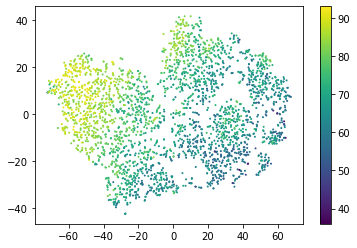

In [195]:
labels = X_test['ExternalRiskEstimate'].tolist()
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=labels, s=1)
plt.colorbar()

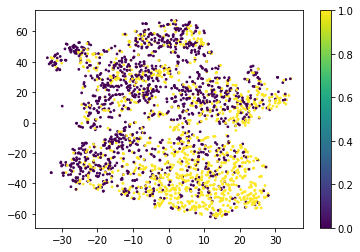

In [157]:
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=y_test, s=3)
plt.colorbar()

In [ ]:
# Apply the probability map

In [172]:
from sklearn.decomposition import PCA
import plotly.express as px


pca = PCA()
components = pca.fit_transform(X_test)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=y_test
)
fig.update_traces(diagonal_visible=True)
fig.show()

In [159]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_test)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=labelled_correctly)

for i, dim in enumerate(X.columns.tolist()):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=dim,
    )
fig.show()

In [169]:
import shap 

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)[1] #Takes a long time

In [170]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0,:], X_test.iloc[0,:])

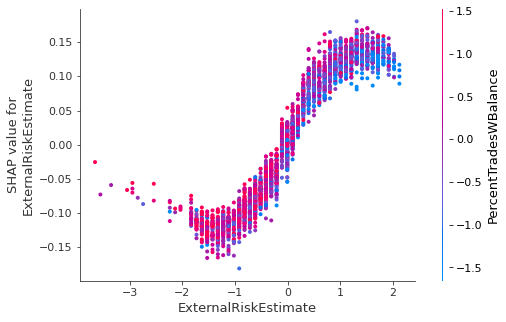

In [171]:
shap.dependence_plot("ExternalRiskEstimate", shap_values, X_test)

In [166]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    X_train.values, 
    mode='classification', 
    feature_names=X_train.columns, 
    verbose=True
)

In [167]:
exp = explainer.explain_instance(X_test.to_numpy()[10], model.predict_proba)
exp.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.47699830087782286
Prediction_local [0.31870016]
Right: 0.2813333333333333


In [168]:
exp.as_list()

[('ExternalRiskEstimate <= -0.82', -0.11866257998116604),
 ('PercentTradesNeverDelq <= -0.29', -0.057857306987315456),
 ('AverageMInFile > 0.53', 0.04600935667534521),
 ('MaxDelq/PublicRecLast12M <= 5.00', -0.03219791850820388),
 ('-0.13 < NetFractionRevolvingBurden <= 0.70', -0.014775551195138166),
 ('MaxDelqEver <= 4.00', -0.00957958672579433),
 ('-0.13 < MSinceOldestTradeOpen <= 0.57', 0.008473771846507201),
 ('-0.68 < NumInqLast6M <= -0.21', 0.007537036550001648),
 ('PercentInstallTrades <= -0.76', 0.007332823243658954),
 ('-0.70 < NumRevolvingTradesWBalance <= -0.03', 0.005421813668277457)]